In [773]:
import sys
import sql
import pandas as pd
from functools import reduce
from tabulate import tabulate
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import common 

In [774]:
q= 'select * from advisory'
df = pd.DataFrame(sql.execute(q))
len(df)

6956

In [775]:
q= ''' select * from advisory where type = 'Malicious Package' '''
df = pd.DataFrame(sql.execute(q))
len(df)

589

In [776]:
q = '''select *
from advisory a
join package p on a.package_id = p.id
where type != 'Malicious Package'
and ecosystem = 'cocoapods' '''
df = pd.DataFrame(sql.execute(q))
len(df), df['id'].nunique(), df['p.id'].nunique()

(358, 358, 37)

In [777]:
q= '''select distinct advisory_id, p.id as package_id, version
from fixing_releases fr
join advisory a on fr.advisory_id = a.id
join package p on a.package_id = p.id
where ecosystem != 'cocoapods'
and type != 'Malicious Package'
and version != %s;'''
df = pd.DataFrame(sql.execute(q, (common.manualcheckup,)))
len(df), df['advisory_id'].nunique()

(7083, 4776)

In [778]:
q= '''select distinct advisory_id
from advisory a
join fixing_releases fr on a.id = fr.advisory_id
join package p on a.package_id = p.id
and ecosystem != 'cocoapods'
and version = 'manual checkup needed'
and advisory_id not in
(select distinct advisory_id
from advisory a
join fixing_releases fr on a.id = fr.advisory_id
join package p on a.package_id = p.id
and ecosystem != 'cocoapods'
and version != 'manual checkup needed')'''
df = pd.DataFrame(sql.execute(q))
df['advisory_id'].nunique()

102

In [779]:
q = '''select *
from advisory a
join package p on a.package_id = p.id
where type != 'Malicious Package'
and ecosystem != 'cocoapods'
and a.id not in
(select advisory_id from fixing_releases)'''
df = pd.DataFrame(sql.execute(q))
len(df), df['id'].nunique()

(1131, 1131)

In [780]:
q= '''select distinct advisory_id, p.id as package_id, version
from fixing_releases fr
join advisory a on fr.advisory_id = a.id
join package p on a.package_id = p.id
where ecosystem != 'cocoapods'
and type != 'Malicious Package'
and version != %s
and repository_url = %s'''
df = pd.DataFrame(sql.execute(q, (common.manualcheckup,common.norepo)))
len(df), df['package_id'].nunique(), df['advisory_id'].nunique()

(518, 300, 399)

In [781]:
q='''select t1.ecosystem as ecosystem, advisories, advisory_with_CVEs, packages, fixing_releases
from
(select ecosystem, count(distinct a.id) as advisories, count(distinct p.id) as packages, count(distinct advisory_id, version) as fixing_releases
from advisory a
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
where type != 'Malicious Package'
and version != 'manual checkup needed'
and ecosystem != 'cocoapods'
and repository_url != 'no repository listed'
group by ecosystem) as t1
join
(select ecosystem, count(distinct a.id) as advisory_with_CVEs
from advisoryCVE aC
join advisory a on aC.advisory_id = a.id
join fixing_releases fr on a.id = fr.advisory_id
join package p on a.package_id = p.id
where type != 'Malicious Package'
and version != 'manual checkup needed'
and ecosystem != 'cocoapods'
and repository_url != 'no repository listed'
group by ecosystem) as t2
on t1.ecosystem = t2.ecosystem
order by ecosystem asc;'''
df = pd.DataFrame(sql.execute(q))

In [782]:
df

,ecosystem,advisories,advisory_with_CVEs,packages,fixing_releases
0,Composer,855,599,228,1733
1,Go,235,190,183,325
2,Maven,1374,1132,694,1950
3,npm,792,474,540,949
4,NuGet,333,277,92,410
5,pip,567,404,269,834
6,RubyGems,221,168,121,364


In [783]:
q = '''select ecosystem, ac.cwe as cwe
from advisory a
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
join advisoryCWE aC on a.id = aC.advisory_id
where type != 'Malicious Package'
and version != 'manual checkup needed'
and ecosystem != 'cocoapods'
and repository_url != 'no repository listed';'''
cwe = pd.DataFrame(sql.execute(q))
total_cwes = cwe['cwe'].nunique()
cwe = cwe.groupby('ecosystem')[['cwe']].nunique()
cwe


,cwe
ecosystem,
Composer,68
Go,50
Maven,112
NuGet,34
RubyGems,47
npm,82
pip,84


In [784]:
df=reduce(lambda x,y : pd.merge(x,y,on='ecosystem'),[df, cwe])
df.reset_index()
df

,ecosystem,advisories,advisory_with_CVEs,packages,fixing_releases,cwe
0,Composer,855,599,228,1733,68
1,Go,235,190,183,325,50
2,Maven,1374,1132,694,1950,112
3,npm,792,474,540,949,82
4,NuGet,333,277,92,410,34
5,pip,567,404,269,834,84
6,RubyGems,221,168,121,364,47


In [785]:
df.loc[len(df)]=['Total',df['advisories'].sum(),df['advisory_with_CVEs'].sum(),df['packages'].sum(), df['fixing_releases'].sum(), total_cwes] 
table = df

In [786]:
q = '''select distinct a.id, p.ecosystem, a.severity
from advisory a
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
join advisoryCWE aC on a.id = aC.advisory_id
where type != 'Malicious Package'
and version != 'manual checkup needed'
and ecosystem != 'cocoapods'
and repository_url != 'no repository listed';'''
sev = pd.DataFrame(sql.execute(q))
l, m, h = sev[sev['severity']=='L'],sev[sev['severity']=='M'],sev[sev['severity']=='H']
eco_l = l.groupby('ecosystem')[['severity']].count()
eco_l = eco_l.rename(columns={'severity':'L'})
eco_m = m.groupby('ecosystem')[['severity']].count()
eco_m = eco_m.rename(columns={'severity':'M'})
eco_h = h.groupby('ecosystem')[['severity']].count()
eco_h = eco_h.rename(columns={'severity':'H'})
sf=reduce(lambda x,y : pd.merge(x,y,on='ecosystem'),[eco_l, eco_m, eco_h])
sf = sf.reset_index()
l,m,h = len(l), len(m), len(h)
sf.loc[len(df)] = ['Total',l,m,h]
sf['T'] = sf.L + sf.M + sf.H
sf['L'] = round(sf['L'] / sf['T'],2)
sf['M'] = round(sf['M'] / sf['T'],2)
sf['H'] = round(sf['H'] / sf['T'],2)
sf['severity'] = sf[['L','M','H']].apply(tuple, axis=1)
sf = sf.drop(['L','M','H','T'], axis=1)
sf

,ecosystem,severity
0,Composer,"(0.04, 0.53, 0.43)"
1,Go,"(0.06, 0.54, 0.4)"
2,Maven,"(0.05, 0.54, 0.41)"
3,NuGet,"(0.02, 0.33, 0.66)"
4,RubyGems,"(0.03, 0.59, 0.38)"
5,npm,"(0.05, 0.47, 0.48)"
6,pip,"(0.06, 0.62, 0.32)"
8,Total,"(0.05, 0.52, 0.43)"


In [787]:
df = reduce(lambda x,y : pd.merge(x,y,on='ecosystem'),[table, sf])
df

,ecosystem,advisories,advisory_with_CVEs,packages,fixing_releases,cwe,severity
0,Composer,855,599,228,1733,68,"(0.04, 0.53, 0.43)"
1,Go,235,190,183,325,50,"(0.06, 0.54, 0.4)"
2,Maven,1374,1132,694,1950,112,"(0.05, 0.54, 0.41)"
3,npm,792,474,540,949,82,"(0.05, 0.47, 0.48)"
4,NuGet,333,277,92,410,34,"(0.02, 0.33, 0.66)"
5,pip,567,404,269,834,84,"(0.06, 0.62, 0.32)"
6,RubyGems,221,168,121,364,47,"(0.03, 0.59, 0.38)"
7,Total,4377,3244,2127,6565,172,"(0.05, 0.52, 0.43)"


In [788]:
df['non-CVEs'] = df['advisories'] - df['advisory_with_CVEs']
df['percent'] = round (df['non-CVEs'] / df['advisories'] * 100 , 1)
df['non-CVEs'] = df['non-CVEs'].map(str) + ' (' + df['percent'].map(str) +'%)'
df.drop('percent', axis = 1)
df['percent'] = round (df['advisory_with_CVEs'] / df['advisories'] * 100 , 1)
df['advisory_with_CVEs'] = df['advisory_with_CVEs'].map(str) + ' (' + df['percent'].map(str) +'%)'
df.drop('percent', axis = 1)

,ecosystem,advisories,advisory_with_CVEs,packages,fixing_releases,cwe,severity,non-CVEs
0,Composer,855,599 (70.1%),228,1733,68,"(0.04, 0.53, 0.43)",256 (29.9%)
1,Go,235,190 (80.9%),183,325,50,"(0.06, 0.54, 0.4)",45 (19.1%)
2,Maven,1374,1132 (82.4%),694,1950,112,"(0.05, 0.54, 0.41)",242 (17.6%)
3,npm,792,474 (59.8%),540,949,82,"(0.05, 0.47, 0.48)",318 (40.2%)
4,NuGet,333,277 (83.2%),92,410,34,"(0.02, 0.33, 0.66)",56 (16.8%)
5,pip,567,404 (71.3%),269,834,84,"(0.06, 0.62, 0.32)",163 (28.7%)
6,RubyGems,221,168 (76.0%),121,364,47,"(0.03, 0.59, 0.38)",53 (24.0%)
7,Total,4377,3244 (74.1%),2127,6565,172,"(0.05, 0.52, 0.43)",1133 (25.9%)


In [789]:
df.columns
cols = ['ecosystem',  'advisories', 'packages', 'fixing_releases',  'cwe', 'severity', 'advisory_with_CVEs', 'non-CVEs']
df =df[cols]
df

,ecosystem,advisories,packages,fixing_releases,cwe,severity,advisory_with_CVEs,non-CVEs
0,Composer,855,228,1733,68,"(0.04, 0.53, 0.43)",599 (70.1%),256 (29.9%)
1,Go,235,183,325,50,"(0.06, 0.54, 0.4)",190 (80.9%),45 (19.1%)
2,Maven,1374,694,1950,112,"(0.05, 0.54, 0.41)",1132 (82.4%),242 (17.6%)
3,npm,792,540,949,82,"(0.05, 0.47, 0.48)",474 (59.8%),318 (40.2%)
4,NuGet,333,92,410,34,"(0.02, 0.33, 0.66)",277 (83.2%),56 (16.8%)
5,pip,567,269,834,84,"(0.06, 0.62, 0.32)",404 (71.3%),163 (28.7%)
6,RubyGems,221,121,364,47,"(0.03, 0.59, 0.38)",168 (76.0%),53 (24.0%)
7,Total,4377,2127,6565,172,"(0.05, 0.52, 0.43)",3244 (74.1%),1133 (25.9%)


In [790]:
print(tabulate(df, tablefmt='latex', headers='keys',showindex=False))

\begin{tabular}{lrrrrlll}
\hline
 ecosystem   &   advisories &   packages &   fixing\_releases &   cwe & severity           & advisory\_with\_CVEs   & non-CVEs     \\
\hline
 Composer    &          855 &        228 &              1733 &    68 & (0.04, 0.53, 0.43) & 599 (70.1\%)          & 256 (29.9\%)  \\
 Go          &          235 &        183 &               325 &    50 & (0.06, 0.54, 0.4)  & 190 (80.9\%)          & 45 (19.1\%)   \\
 Maven       &         1374 &        694 &              1950 &   112 & (0.05, 0.54, 0.41) & 1132 (82.4\%)         & 242 (17.6\%)  \\
 npm         &          792 &        540 &               949 &    82 & (0.05, 0.47, 0.48) & 474 (59.8\%)          & 318 (40.2\%)  \\
 NuGet       &          333 &         92 &               410 &    34 & (0.02, 0.33, 0.66) & 277 (83.2\%)          & 56 (16.8\%)   \\
 pip         &          567 &        269 &               834 &    84 & (0.06, 0.62, 0.32) & 404 (71.3\%)          & 163 (28.7\%)  \\
 RubyGems    &          221 

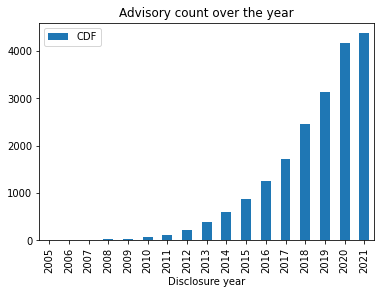

In [791]:
q= '''select year(a.disclose_date) as disclose_year, count(distinct a.id) as count
from advisory a
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
where type != 'Malicious Package'
and version != 'manual checkup needed'
and ecosystem != 'cocoapods'
and repository_url != 'no repository listed'
group by year(a.disclose_date);'''
df = pd.DataFrame(sql.execute(q))
df['cdf']=df['count'].cumsum()
df = df.rename(columns = {'disclose_year':'Disclosure year', 'cdf':'CDF'})
fig = df.plot(x='Disclosure year',y='CDF',kind='bar', title = 'Advisory count over the year').get_figure()

In [792]:
fig.savefig('cdf_disclose.png')


In [793]:
df

,Disclosure year,count,CDF
0,2005,2,2
1,2006,4,6
2,2007,4,10
3,2008,10,20
4,2009,6,26
5,2010,45,71
6,2011,48,119
7,2012,105,224
8,2013,169,393
9,2014,203,596


In [794]:
(4377 - 872) / 4377

0.8007767877541695

In [795]:
(4377 - 872)

3505